# **Task - 1 -  Movie Ratings Analytics with PySpark**



In [11]:

!pip install -q pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg as _avg, max as _max, count as _count, desc
spark = SparkSession.builder.appName("Movie-Capstone").getOrCreate()
sc = spark.sparkContext

print("Spark Started:", spark)


Spark Started: <pyspark.sql.session.SparkSession object at 0x7d2c2a88c050>


### **Prepare Data**

In [12]:


# Users
users_data = [
 (1, "Rahul", 25, "Bangalore"),
 (2, "Priya", 30, "Delhi"),
 (3, "Aman", 22, "Hyderabad"),
 (4, "Sneha", 28, "Chennai"),
 (5, "Arjun", 35, "Mumbai")
]
users_cols = ["user_id", "name", "age", "city"]
users_df = spark.createDataFrame(users_data, users_cols)

# Movies
movies_data = [
 (101, "Inception", "Sci-Fi", 2010),
 (102, "Avengers", "Action", 2012),
 (103, "3 Idiots", "Comedy", 2009),
 (104, "Dangal", "Drama", 2016),
 (105, "Interstellar", "Sci-Fi", 2014)
]
movies_cols = ["movie_id", "title", "genre", "year"]
movies_df = spark.createDataFrame(movies_data, movies_cols)

# Ratings
ratings_data = [
 (1, 101, 5),
 (2, 101, 4),
 (1, 102, 3),
 (3, 103, 4),
 (4, 104, 5),
 (2, 103, 5),
 (5, 105, 4),
 (6, 101, 5)
]
ratings_cols = ["user_id", "movie_id", "rating"]
ratings_df = spark.createDataFrame(ratings_data, ratings_cols)

print("Users:")
users_df.show()
print("Movies:")
movies_df.show()
print("Ratings:")
ratings_df.show()


Users:
+-------+-----+---+---------+
|user_id| name|age|     city|
+-------+-----+---+---------+
|      1|Rahul| 25|Bangalore|
|      2|Priya| 30|    Delhi|
|      3| Aman| 22|Hyderabad|
|      4|Sneha| 28|  Chennai|
|      5|Arjun| 35|   Mumbai|
+-------+-----+---+---------+

Movies:
+--------+------------+------+----+
|movie_id|       title| genre|year|
+--------+------------+------+----+
|     101|   Inception|Sci-Fi|2010|
|     102|    Avengers|Action|2012|
|     103|    3 Idiots|Comedy|2009|
|     104|      Dangal| Drama|2016|
|     105|Interstellar|Sci-Fi|2014|
+--------+------------+------+----+

Ratings:
+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|      1|     101|     5|
|      2|     101|     4|
|      1|     102|     3|
|      3|     103|     4|
|      4|     104|     5|
|      2|     103|     5|
|      5|     105|     4|
|      6|     101|     5|
+-------+--------+------+



### **DataFrame Basics**

In [13]:
# Users older than 28
users_df.filter(col("age") > 28).show()

# Distinct movie genres
movies_df.select("genre").distinct().show()

# Movies released after 2010
movies_df.filter(col("year") > 2010).show()


+-------+-----+---+------+
|user_id| name|age|  city|
+-------+-----+---+------+
|      2|Priya| 30| Delhi|
|      5|Arjun| 35|Mumbai|
+-------+-----+---+------+

+------+
| genre|
+------+
|Action|
|Sci-Fi|
| Drama|
|Comedy|
+------+

+--------+------------+------+----+
|movie_id|       title| genre|year|
+--------+------------+------+----+
|     102|    Avengers|Action|2012|
|     104|      Dangal| Drama|2016|
|     105|Interstellar|Sci-Fi|2014|
+--------+------------+------+----+



### **Aggregations**

In [14]:
# Average age of users per city
users_df.groupBy("city").agg(_avg("age").alias("avg_age")).show()

# Average rating for each movie
ratings_df.groupBy("movie_id").agg(_avg("rating").alias("avg_rating")).show()

# Highest-rated movie in each genre
avg_ratings = ratings_df.groupBy("movie_id").agg(_avg("rating").alias("avg_rating"))
ratings_with_movies = avg_ratings.join(movies_df, on="movie_id", how="left")

from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

window = Window.partitionBy("genre").orderBy(desc("avg_rating"))
highest_rated_per_genre = ratings_with_movies.withColumn("rank", row_number().over(window)) \
    .filter(col("rank") == 1)

highest_rated_per_genre.select("genre", "title", "avg_rating").show()


+---------+-------+
|     city|avg_age|
+---------+-------+
|Bangalore|   25.0|
|    Delhi|   30.0|
|  Chennai|   28.0|
|   Mumbai|   35.0|
|Hyderabad|   22.0|
+---------+-------+

+--------+-----------------+
|movie_id|       avg_rating|
+--------+-----------------+
|     103|              4.5|
|     101|4.666666666666667|
|     102|              3.0|
|     104|              5.0|
|     105|              4.0|
+--------+-----------------+

+------+---------+-----------------+
| genre|    title|       avg_rating|
+------+---------+-----------------+
|Action| Avengers|              3.0|
|Comedy| 3 Idiots|              4.5|
| Drama|   Dangal|              5.0|
|Sci-Fi|Inception|4.666666666666667|
+------+---------+-----------------+



### **Joins**

In [15]:
# Join ratings with users -> who rated what
ratings_with_users = ratings_df.join(users_df, on="user_id", how="inner") \
    .select("user_id", "name", "movie_id", "rating")
ratings_with_users.show()

# Join ratings with movies -> ratings with movie names
ratings_with_movies = ratings_df.join(movies_df, on="movie_id", how="inner") \
    .select("user_id", "movie_id", "title", "genre", "rating")
ratings_with_movies.show()

# Users who never rated a movie
users_never_rated = users_df.join(ratings_df, on="user_id", how="left_anti")
users_never_rated.show()

# Movies that were never rated
movies_never_rated = movies_df.join(ratings_df, on="movie_id", how="left_anti")
movies_never_rated.show()


+-------+-----+--------+------+
|user_id| name|movie_id|rating|
+-------+-----+--------+------+
|      1|Rahul|     101|     5|
|      1|Rahul|     102|     3|
|      2|Priya|     101|     4|
|      2|Priya|     103|     5|
|      3| Aman|     103|     4|
|      4|Sneha|     104|     5|
|      5|Arjun|     105|     4|
+-------+-----+--------+------+

+-------+--------+------------+------+------+
|user_id|movie_id|       title| genre|rating|
+-------+--------+------------+------+------+
|      1|     101|   Inception|Sci-Fi|     5|
|      2|     101|   Inception|Sci-Fi|     4|
|      6|     101|   Inception|Sci-Fi|     5|
|      1|     102|    Avengers|Action|     3|
|      3|     103|    3 Idiots|Comedy|     4|
|      2|     103|    3 Idiots|Comedy|     5|
|      4|     104|      Dangal| Drama|     5|
|      5|     105|Interstellar|Sci-Fi|     4|
+-------+--------+------------+------+------+

+-------+----+---+----+
|user_id|name|age|city|
+-------+----+---+----+
+-------+----+---+----

### **SQL Queries**

In [16]:
# Register as temp views
users_df.createOrReplaceTempView("users")
movies_df.createOrReplaceTempView("movies")
ratings_df.createOrReplaceTempView("ratings")

# Top 2 cities by number of ratings given
q12 = """
SELECT u.city, COUNT(r.rating) AS total_ratings
FROM ratings r
JOIN users u ON r.user_id = u.user_id
GROUP BY u.city
ORDER BY total_ratings DESC
LIMIT 2
"""
spark.sql(q12).show()

# Users who gave at least one 5-star rating
q13 = """
SELECT DISTINCT u.user_id, u.name
FROM ratings r
JOIN users u ON r.user_id = u.user_id
WHERE r.rating = 5
"""
spark.sql(q13).show()

# Most popular genre by number of ratings
q14 = """
SELECT m.genre, COUNT(r.rating) AS total_ratings
FROM ratings r
JOIN movies m ON r.movie_id = m.movie_id
GROUP BY m.genre
ORDER BY total_ratings DESC
LIMIT 1
"""
spark.sql(q14).show()


+---------+-------------+
|     city|total_ratings|
+---------+-------------+
|Bangalore|            2|
|    Delhi|            2|
+---------+-------------+

+-------+-----+
|user_id| name|
+-------+-----+
|      1|Rahul|
|      2|Priya|
|      4|Sneha|
+-------+-----+

+------+-------------+
| genre|total_ratings|
+------+-------------+
|Sci-Fi|            4|
+------+-------------+



### **File I/O**

In [17]:
# Save ratings_df as CSV and reload
ratings_path = "/content/ratings_csv"
ratings_df.coalesce(1).write.mode("overwrite").option("header", True).csv(ratings_path)

ratings_loaded = spark.read.option("header", True).option("inferSchema", True).csv(ratings_path)
ratings_loaded.show()

# Save movies_df as JSON and reload
movies_path = "/content/movies_json"
movies_df.coalesce(1).write.mode("overwrite").json(movies_path)

movies_loaded = spark.read.json(movies_path)
movies_loaded.show()


+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|      1|     101|     5|
|      2|     101|     4|
|      1|     102|     3|
|      3|     103|     4|
|      4|     104|     5|
|      2|     103|     5|
|      5|     105|     4|
|      6|     101|     5|
+-------+--------+------+

+------+--------+------------+----+
| genre|movie_id|       title|year|
+------+--------+------------+----+
|Sci-Fi|     101|   Inception|2010|
|Action|     102|    Avengers|2012|
|Comedy|     103|    3 Idiots|2009|
| Drama|     104|      Dangal|2016|
|Sci-Fi|     105|Interstellar|2014|
+------+--------+------------+----+



### **Visualization**

    genre  avg_rating
0  Action         3.0
1  Comedy         4.5
2   Drama         5.0
3  Sci-Fi         4.5


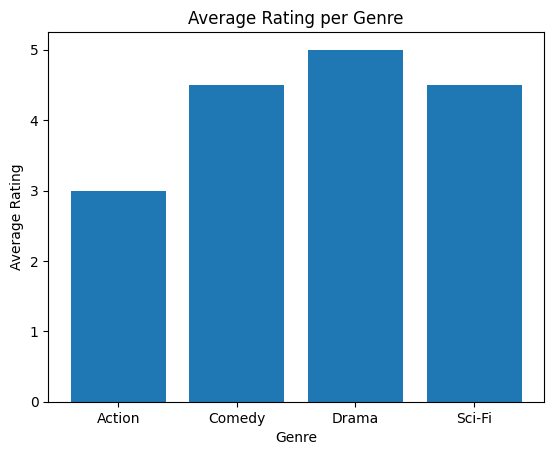

   year  num_ratings
0  2009            2
1  2010            3
2  2012            1
3  2014            1
4  2016            1


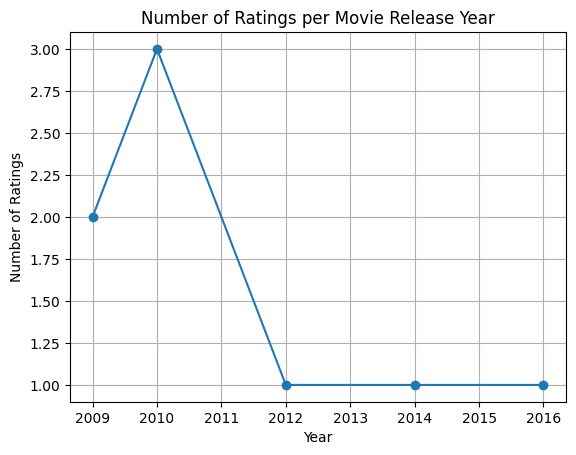

   age  avg_rating
0   25         4.0
1   30         4.5
2   35         4.0
3   22         4.0
4   28         5.0


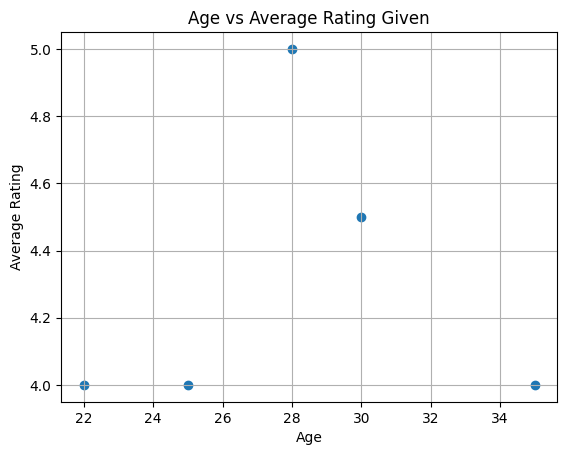

In [18]:
import matplotlib.pyplot as plt

# Convert PySpark DataFrame -> Pandas
avg_rating_genre = ratings_df.join(movies_df, on="movie_id", how="left") \
    .groupBy("genre").agg(_avg("rating").alias("avg_rating")).orderBy("genre")

avg_rating_genre_pd = avg_rating_genre.toPandas()
print(avg_rating_genre_pd)

# Bar chart – Average rating per genre
plt.figure()
plt.bar(avg_rating_genre_pd['genre'], avg_rating_genre_pd['avg_rating'])
plt.title("Average Rating per Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.show()

# Line chart – Number of ratings per movie release year
ratings_year = ratings_df.join(movies_df, on="movie_id", how="left") \
    .groupBy("year").agg(_count("rating").alias("num_ratings")).orderBy("year")

ratings_year_pd = ratings_year.toPandas()
print(ratings_year_pd)

plt.figure()
plt.plot(ratings_year_pd['year'], ratings_year_pd['num_ratings'], marker='o')
plt.title("Number of Ratings per Movie Release Year")
plt.xlabel("Year")
plt.ylabel("Number of Ratings")
plt.grid(True)
plt.show()

# Scatter plot – Age vs Average rating given
user_avg_rating = ratings_df.groupBy("user_id").agg(_avg("rating").alias("avg_rating"))
age_vs_rating = user_avg_rating.join(users_df, on="user_id", how="inner") \
    .select("age", "avg_rating")

age_vs_rating_pd = age_vs_rating.toPandas()
print(age_vs_rating_pd)

plt.figure()
plt.scatter(age_vs_rating_pd['age'], age_vs_rating_pd['avg_rating'])
plt.title("Age vs Average Rating Given")
plt.xlabel("Age")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()





# **Task - 2 - Retail Sales Analytics with PySpark**

In [19]:

!pip install -q pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, avg as _avg, max as _max, min as _min, count as _count, desc, month, to_date
from pyspark.sql.types import IntegerType, DateType

spark = SparkSession.builder.appName("Retail-Capstone").getOrCreate()
sc = spark.sparkContext

print("Spark started:", spark)


Spark started: <pyspark.sql.session.SparkSession object at 0x7d2c2a88c050>


### **Prepare Data**

In [20]:


# Customers
customers_data = [
 (1, "Rahul Sharma", "Bangalore", 28),
 (2, "Priya Singh", "Delhi", 32),
 (3, "Aman Kumar", "Hyderabad", 25),
 (4, "Sneha Reddy", "Chennai", 35),
 (5, "Arjun Mehta", "Mumbai", 30),
 (6, "Divya Nair", "Delhi", 29)
]
customers_cols = ["customer_id", "name", "city", "age"]
customers_df = spark.createDataFrame(customers_data, customers_cols)

# Products
products_data = [
 (101, "Laptop", "Electronics", 55000),
 (102, "Mobile", "Electronics", 25000),
 (103, "Headphones", "Electronics", 3000),
 (104, "Chair", "Furniture", 5000),
 (105, "Book", "Stationery", 700),
 (106, "Shoes", "Fashion", 2500)
]
products_cols = ["product_id", "product_name", "category", "price"]
products_df = spark.createDataFrame(products_data, products_cols)

# Orders
orders_data = [
 (1001, 1, 101, 1, "2024-01-10"),
 (1002, 2, 102, 2, "2024-01-12"),
 (1003, 1, 103, 3, "2024-02-05"),
 (1004, 3, 104, 1, "2024-02-08"),
 (1005, 5, 105, 5, "2024-03-01"),
 (1006, 6, 106, 2, "2024-03-15"),
 (1007, 7, 101, 1, "2024-03-20")  # non-existent customer
]
orders_cols = ["order_id", "customer_id", "product_id", "quantity", "order_date"]
orders_df = spark.createDataFrame(orders_data, orders_cols)

# Convert order_date to actual DateType
orders_df = orders_df.withColumn("order_date", to_date(col("order_date"), "yyyy-MM-dd"))

# Show schemas and small sample
print("Customers schema:")
customers_df.printSchema()
customers_df.show()

print("Products schema:")
products_df.printSchema()
products_df.show()

print("Orders schema:")
orders_df.printSchema()
orders_df.show()


Customers schema:
root
 |-- customer_id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- age: long (nullable = true)

+-----------+------------+---------+---+
|customer_id|        name|     city|age|
+-----------+------------+---------+---+
|          1|Rahul Sharma|Bangalore| 28|
|          2| Priya Singh|    Delhi| 32|
|          3|  Aman Kumar|Hyderabad| 25|
|          4| Sneha Reddy|  Chennai| 35|
|          5| Arjun Mehta|   Mumbai| 30|
|          6|  Divya Nair|    Delhi| 29|
+-----------+------------+---------+---+

Products schema:
root
 |-- product_id: long (nullable = true)
 |-- product_name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- price: long (nullable = true)

+----------+------------+-----------+-----+
|product_id|product_name|   category|price|
+----------+------------+-----------+-----+
|       101|      Laptop|Electronics|55000|
|       102|      Mobile|Electronics|25000|
|       103|  Hea

###  **RDD Basics**

In [21]:
# RDD from list of numbers and basic stats
numbers = [10, 20, 30, 40, 50]
num_rdd = sc.parallelize(numbers)

# sum, max, min, average
total_sum = num_rdd.reduce(lambda a, b: a + b)
max_val = num_rdd.reduce(lambda a, b: a if a > b else b)
min_val = num_rdd.reduce(lambda a, b: a if a < b else b)
count = num_rdd.count()
average = total_sum / count

print("Numbers RDD:", numbers)
print("Sum:", total_sum)
print("Max:", max_val)
print("Min:", min_val)
print("Count:", count)
print("Average:", average)


Numbers RDD: [10, 20, 30, 40, 50]
Sum: 150
Max: 50
Min: 10
Count: 5
Average: 30.0


In [22]:
#  RDD of sentences -> word count
sentences = [
 "spark is great for large scale data processing",
 "pyspark lets you use spark with python",
 "word count is a classic rdd example"
]
sent_rdd = sc.parallelize(sentences)

# split into words, map to (word,1), reduceByKey
words_rdd = sent_rdd.flatMap(lambda s: s.split())
pairs = words_rdd.map(lambda w: (w.lower(), 1))
word_counts = pairs.reduceByKey(lambda a, b: a + b)

print("Word counts:")
for w, c in word_counts.collect():
    print(w, c)


Word counts:
for 1
large 1
lets 1
you 1
use 1
with 1
python 1
word 1
rdd 1
spark 2
is 2
great 1
scale 1
data 1
processing 1
pyspark 1
count 1
a 1
classic 1
example 1


### **DataFrame Operations**

In [23]:
# Show all customer names and their cities
customers_df.select("name", "city").show()

# Find customers older than 30
customers_df.filter(col("age") > 30).show()

# List distinct product categories
products_df.select("category").distinct().show()

# Top 3 most expensive products
products_df.orderBy(col("price").desc()).limit(3).show()


+------------+---------+
|        name|     city|
+------------+---------+
|Rahul Sharma|Bangalore|
| Priya Singh|    Delhi|
|  Aman Kumar|Hyderabad|
| Sneha Reddy|  Chennai|
| Arjun Mehta|   Mumbai|
|  Divya Nair|    Delhi|
+------------+---------+

+-----------+-----------+-------+---+
|customer_id|       name|   city|age|
+-----------+-----------+-------+---+
|          2|Priya Singh|  Delhi| 32|
|          4|Sneha Reddy|Chennai| 35|
+-----------+-----------+-------+---+

+-----------+
|   category|
+-----------+
|Electronics|
| Stationery|
|    Fashion|
|  Furniture|
+-----------+

+----------+------------+-----------+-----+
|product_id|product_name|   category|price|
+----------+------------+-----------+-----+
|       101|      Laptop|Electronics|55000|
|       102|      Mobile|Electronics|25000|
|       104|       Chair|  Furniture| 5000|
+----------+------------+-----------+-----+



### **Aggregations**

In [24]:
# Average age of customers per city
customers_df.groupBy("city").agg(_avg("age").alias("avg_age")).show()

# Total revenue per product = price * total_quantity_sold
# First, aggregate total quantity sold per product from orders
qty_per_product = orders_df.groupBy("product_id").agg(_sum("quantity").alias("total_quantity"))

# Join with products to get price, compute revenue
revenue_per_product = qty_per_product.join(products_df, on="product_id", how="left") \
    .withColumn("revenue", col("total_quantity") * col("price")) \
    .select("product_id", "product_name", "total_quantity", "price", "revenue")

revenue_per_product.show()

# Most popular product by total quantity sold
revenue_per_product.orderBy(col("total_quantity").desc()).limit(1).show()


+---------+-------+
|     city|avg_age|
+---------+-------+
|Bangalore|   28.0|
|    Delhi|   30.5|
|Hyderabad|   25.0|
|  Chennai|   35.0|
|   Mumbai|   30.0|
+---------+-------+

+----------+------------+--------------+-----+-------+
|product_id|product_name|total_quantity|price|revenue|
+----------+------------+--------------+-----+-------+
|       103|  Headphones|             3| 3000|   9000|
|       101|      Laptop|             2|55000| 110000|
|       102|      Mobile|             2|25000|  50000|
|       104|       Chair|             1| 5000|   5000|
|       106|       Shoes|             2| 2500|   5000|
|       105|        Book|             5|  700|   3500|
+----------+------------+--------------+-----+-------+

+----------+------------+--------------+-----+-------+
|product_id|product_name|total_quantity|price|revenue|
+----------+------------+--------------+-----+-------+
|       105|        Book|             5|  700|   3500|
+----------+------------+--------------+-----+--

### **Joins**

In [25]:
# Join customers with orders to list each customer's purchases (inner join)
cust_orders_inner = customers_df.join(orders_df, on="customer_id", how="inner") \
    .select("customer_id", "name", "order_id", "product_id", "quantity", "order_date")
cust_orders_inner.show()

# Join orders with products -> order details (product name + category)
orders_with_products = orders_df.join(products_df, on="product_id", how="left") \
    .select("order_id", "customer_id", "product_id", "product_name", "category", "quantity", "order_date")
orders_with_products.show()

# Customers who never placed an order
customers_never_ordered = customers_df.join(orders_df, on="customer_id", how="left_anti")
customers_never_ordered.show()

# Products that were never ordered
products_never_ordered = products_df.join(orders_df, on="product_id", how="left_anti")
products_never_ordered.show()


+-----------+------------+--------+----------+--------+----------+
|customer_id|        name|order_id|product_id|quantity|order_date|
+-----------+------------+--------+----------+--------+----------+
|          1|Rahul Sharma|    1001|       101|       1|2024-01-10|
|          1|Rahul Sharma|    1003|       103|       3|2024-02-05|
|          2| Priya Singh|    1002|       102|       2|2024-01-12|
|          3|  Aman Kumar|    1004|       104|       1|2024-02-08|
|          5| Arjun Mehta|    1005|       105|       5|2024-03-01|
|          6|  Divya Nair|    1006|       106|       2|2024-03-15|
+-----------+------------+--------+----------+--------+----------+

+--------+-----------+----------+------------+-----------+--------+----------+
|order_id|customer_id|product_id|product_name|   category|quantity|order_date|
+--------+-----------+----------+------------+-----------+--------+----------+
|    1003|          1|       103|  Headphones|Electronics|       3|2024-02-05|
|    1001|   

### **SQL Queries**

In [26]:
# Register DataFrames as temp views
customers_df.createOrReplaceTempView("customers")
products_df.createOrReplaceTempView("products")
orders_df.createOrReplaceTempView("orders")

# Top 2 cities by total revenue
q15 = """
SELECT c.city, SUM(o.quantity * p.price) AS total_revenue
FROM orders o
JOIN products p ON o.product_id = p.product_id
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.city
ORDER BY total_revenue DESC
LIMIT 2
"""
spark.sql(q15).show()

# Customers who spent more than 50,000 in total
q16 = """
SELECT c.customer_id, c.name, SUM(o.quantity * p.price) AS total_spent
FROM orders o
JOIN products p ON o.product_id = p.product_id
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.customer_id, c.name
HAVING total_spent > 50000
"""
spark.sql(q16).show()

# Best-selling product category by revenue
q17 = """
SELECT p.category, SUM(o.quantity * p.price) AS revenue
FROM orders o
JOIN products p ON o.product_id = p.product_id
GROUP BY p.category
ORDER BY revenue DESC
LIMIT 1
"""
spark.sql(q17).show()


+---------+-------------+
|     city|total_revenue|
+---------+-------------+
|Bangalore|        64000|
|    Delhi|        55000|
+---------+-------------+

+-----------+------------+-----------+
|customer_id|        name|total_spent|
+-----------+------------+-----------+
|          1|Rahul Sharma|      64000|
+-----------+------------+-----------+

+-----------+-------+
|   category|revenue|
+-----------+-------+
|Electronics| 169000|
+-----------+-------+



### **File I/O (CSV & JSON)**

In [27]:
# Save orders_df as CSV
orders_csv_path = "/content/orders_csv"
orders_df.coalesce(1).write.mode("overwrite").option("header", True).csv(orders_csv_path)
print("Orders saved to:", orders_csv_path)

# Load it back
orders_loaded = spark.read.option("header", True).option("inferSchema", True).csv(orders_csv_path)
orders_loaded = orders_loaded.withColumn("order_date", to_date(col("order_date"), "yyyy-MM-dd"))
orders_loaded.printSchema()
orders_loaded.show()

# Save products_df as JSON and reload
products_json_path = "/content/products_json"
products_df.coalesce(1).write.mode("overwrite").json(products_json_path)
print("Products saved to:", products_json_path)

products_loaded = spark.read.json(products_json_path)
products_loaded.printSchema()
products_loaded.show()


Orders saved to: /content/orders_csv
root
 |-- order_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- order_date: date (nullable = true)

+--------+-----------+----------+--------+----------+
|order_id|customer_id|product_id|quantity|order_date|
+--------+-----------+----------+--------+----------+
|    1001|          1|       101|       1|2024-01-10|
|    1002|          2|       102|       2|2024-01-12|
|    1003|          1|       103|       3|2024-02-05|
|    1004|          3|       104|       1|2024-02-08|
|    1005|          5|       105|       5|2024-03-01|
|    1006|          6|       106|       2|2024-03-15|
|    1007|          7|       101|       1|2024-03-20|
+--------+-----------+----------+--------+----------+

Products saved to: /content/products_json
root
 |-- category: string (nullable = true)
 |-- price: long (nullable = true)
 |-- product_id: long (nullable

### **Visualization**

      category  revenue
0  Electronics   169000
1      Fashion     5000
2    Furniture     5000
3   Stationery     3500


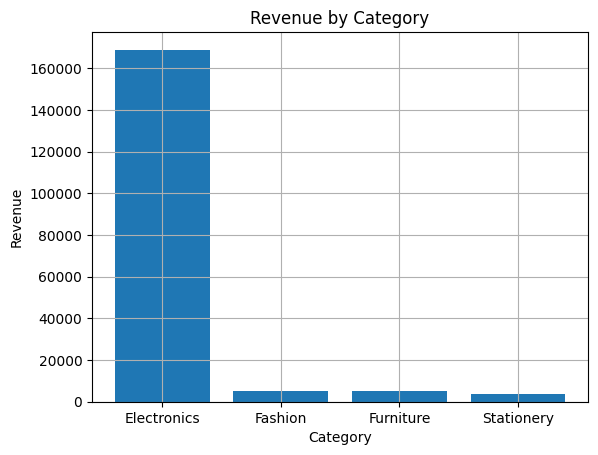

   month  num_orders
0      1           2
1      2           2
2      3           3


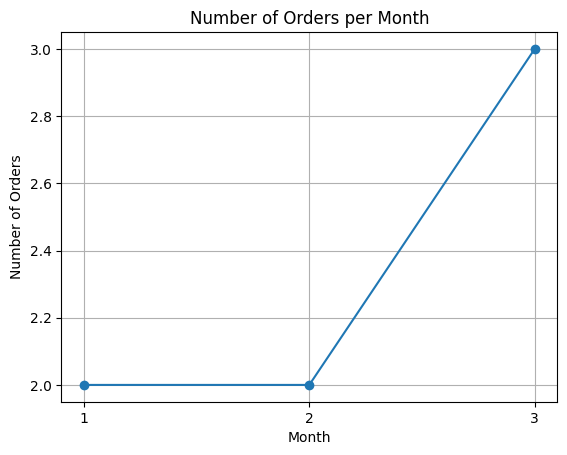

   order_id  product_id  quantity  line_revenue
0      1003         103         3          9000
1      1001         101         1         55000
2      1002         102         2         50000
3      1004         104         1          5000
4      1006         106         2          5000
5      1005         105         5          3500
6      1007         101         1         55000


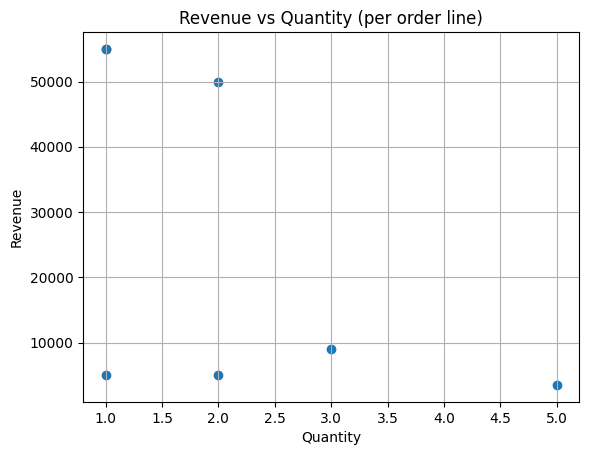

In [28]:
#  Convert PySpark DataFrame -> Pandas
# Prepare revenue by category (PySpark), then toPandas()
revenue_by_cat = orders_df.join(products_df, on="product_id", how="left") \
    .groupBy("category") \
    .agg(_sum(col("quantity") * col("price")).alias("revenue")) \
    .orderBy("category")

revenue_pd = revenue_by_cat.toPandas()
print(revenue_pd)

# Plot Revenue by Category (bar chart)
import matplotlib.pyplot as plt

plt.figure()
plt.bar(revenue_pd['category'], revenue_pd['revenue'])
plt.title("Revenue by Category")
plt.xlabel("Category")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()

# Plot Number of Orders per Month as a line chart
orders_by_month = orders_df.withColumn("month", month(col("order_date"))) \
    .groupBy("month").agg(_count("order_id").alias("num_orders")).orderBy("month")

orders_by_month_pd = orders_by_month.toPandas()
print(orders_by_month_pd)

plt.figure()
plt.plot(orders_by_month_pd['month'], orders_by_month_pd['num_orders'], marker='o')
plt.title("Number of Orders per Month")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.xticks(orders_by_month_pd['month'])
plt.grid(True)
plt.show()

# Plot Revenue vs Quantity as scatter plot
# Build a DataFrame with revenue per order line = price * quantity
order_line = orders_df.join(products_df, on="product_id", how="left") \
    .withColumn("line_revenue", col("quantity") * col("price")) \
    .select("order_id", "product_id", "quantity", "line_revenue")

order_line_pd = order_line.toPandas()
print(order_line_pd)

plt.figure()
plt.scatter(order_line_pd['quantity'], order_line_pd['line_revenue'])
plt.title("Revenue vs Quantity (per order line)")
plt.xlabel("Quantity")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()


